In [50]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams["figure.figsize"] = (20,10)
df5 = pd.read_csv("BHD_Featured.csv")

In [33]:
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2,51.00,2,4250.000000


In [36]:
#outlier -data errors or extreme variation(even though valid), we try to remove them so issues are not created later on
#there are diff techniques for that
#here we will set a threshold, for min area per bedroom(300/bed)


In [37]:
#finding records having less than 300 area
df5[(df5.total_sqft/df5.bhk)<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6,370.0,6,36274.509800
45,HSR Layout,8 Bedroom,600.0,9,200.0,8,33333.333330
57,Murugeshpalya,6 Bedroom,1407.0,4,150.0,6,10660.980810
67,Devarachikkanahalli,8 Bedroom,1350.0,7,85.0,8,6296.296296
69,other,3 Bedroom,500.0,3,100.0,3,20000.000000


In [38]:
df5.shape

(13246, 7)

In [39]:
#we need to remove these records
df6 = df5[~(df5.total_sqft/df5.bhk<300)]

In [41]:
#some records removed in df6
df6.shape

(12502, 7)

In [42]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127338
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588200
Name: price_per_sqft, dtype: float64

In [44]:
#here min and max are too extremes, we can remove because we are trying to prepare generic model
#function to remove extreme cases based on mean,sd
#considering values between mean and 1 sd(filter out anything beyond 1 sd)
#finding mean and sd per location
def remove_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        sd = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-sd)) & (subdf.price_per_sqft<=(m+sd))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

df7 = remove_outliers(df6)
df7.shape

(10241, 7)

In [45]:
df6.shape
#so around 2k rows reduced

(12502, 7)

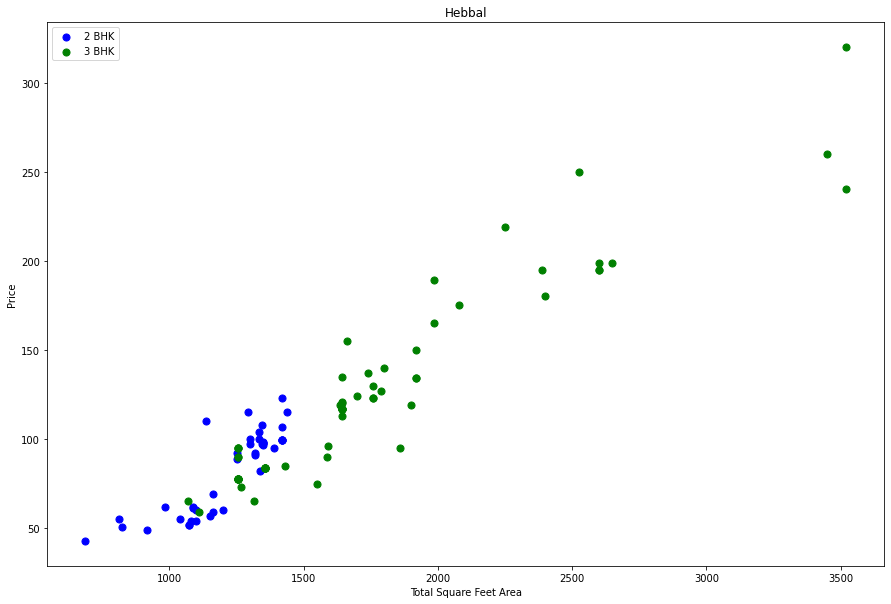

In [53]:
#Scatterplot for visualization
#we want 2bhk prices to be less than 3bhk
import matplotlib
def plot_scatter_chart(df, location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,color='green',label='3 BHK', s=50)
    plt.xlabel('Total Square Feet Area')
    plt.ylabel('Price')
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7, "Hebbal")

In [ ]:
#you can see at some places 2bhk prices(blue) are more  and overlaping with 3bhk

In [63]:
#function to remove values of 3bhk overlapping with 2bhk

def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk,bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean' : np.mean(bhk_df.price_per_sqft),
                'std' : np.std(bhk_df.price_per_sqft),
                'count' : bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

df8 = remove_bhk_outliers(df7)
df8.shape

(7329, 7)

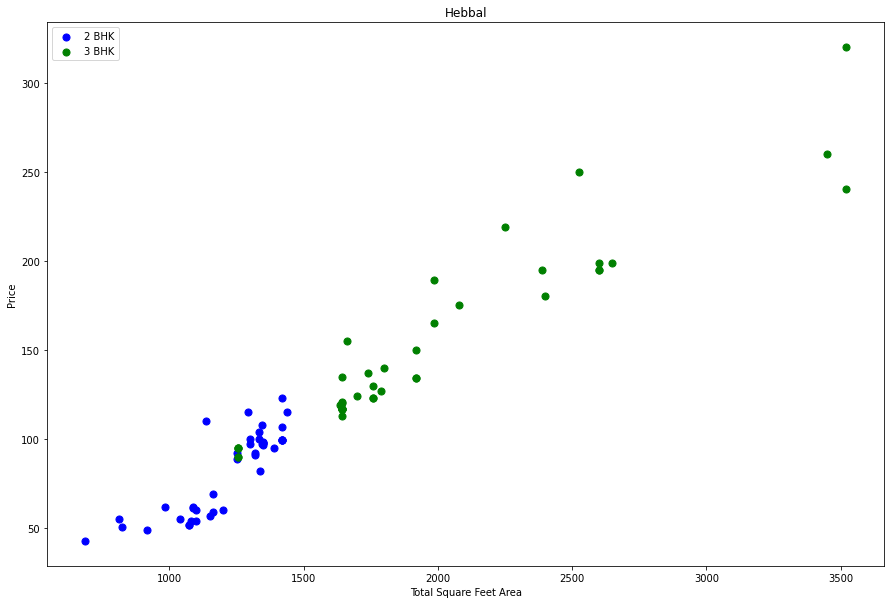

In [64]:
plot_scatter_chart(df8, "Hebbal")

Text(0, 0.5, 'Count')

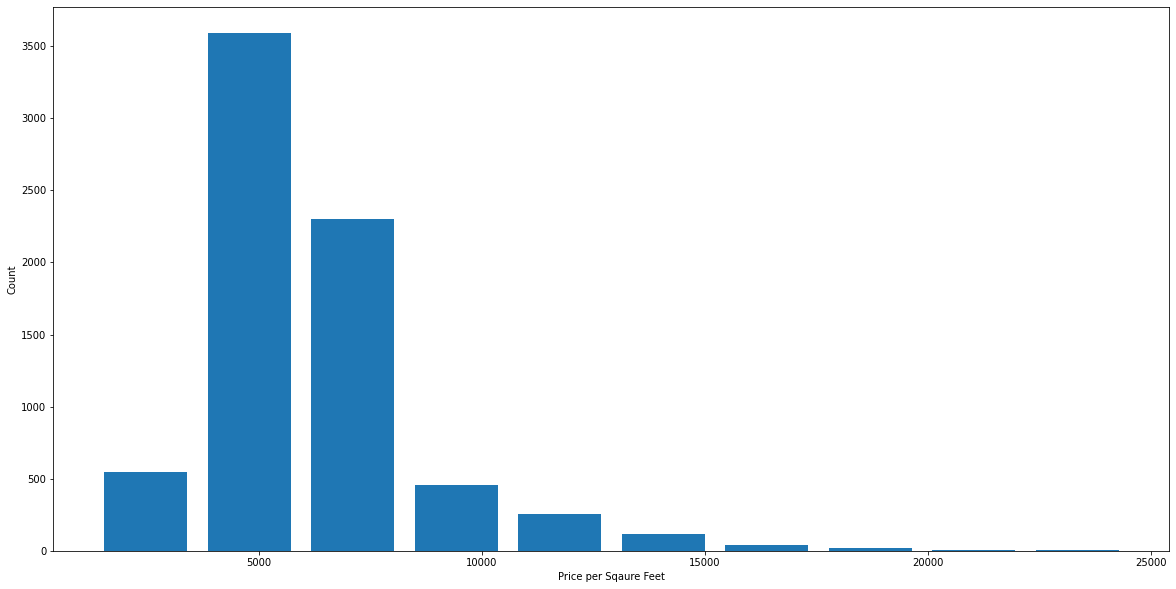

In [66]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft, rwidth=0.8)
plt.xlabel("Price per Sqaure Feet")
plt.ylabel("Count")

In [ ]:
# 0-10000 has majority of data points

In [67]:
df8.bath.unique()

array([ 4,  3,  2,  5,  8,  1,  6,  7,  9, 12, 16, 13], dtype=int64)

In [68]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12,160.0,10,4000.000000
8486,other,10 BHK,12000.0,12,525.0,10,4375.000000
8575,other,16 BHK,10000.0,16,550.0,16,5500.000000
9308,other,11 BHK,6000.0,12,150.0,11,2500.000000
9639,other,13 BHK,5425.0,13,275.0,13,5069.124424


Text(0, 0.5, 'Count')

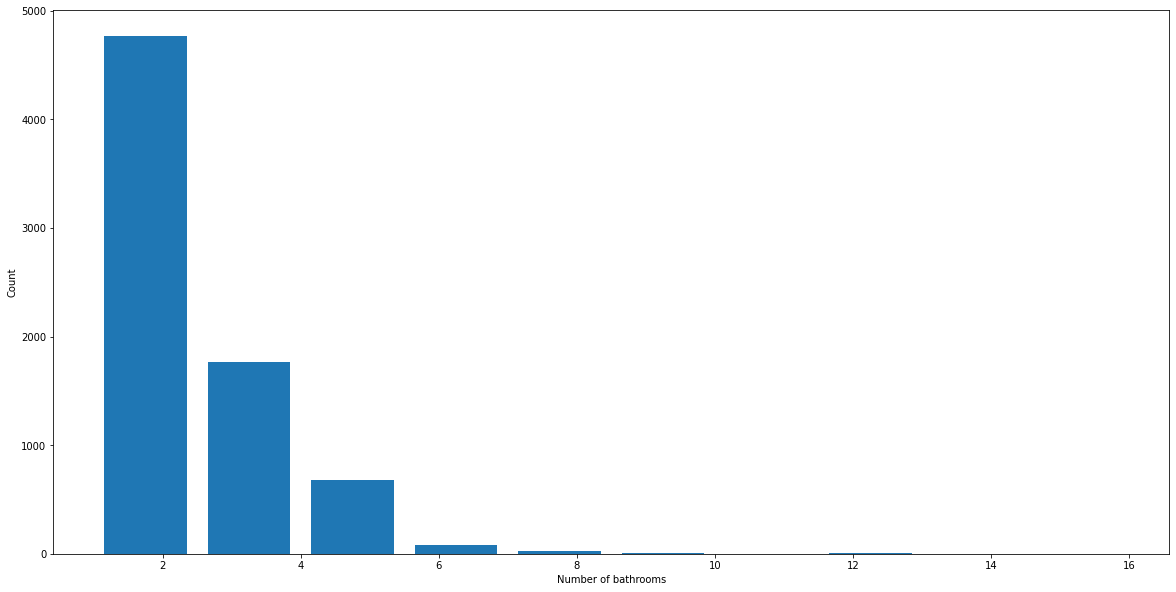

In [72]:
#hist to see majority of bathrooms

plt.hist(df8.bath, rwidth=0.8)
plt.xlabel('Number of bathrooms')
plt.ylabel('Count')

In [73]:
#we are removing rows that has baths>beds- outlier
df8[df8.bath>(df8.bhk+2)]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6,116.0,3,6423.034330
8411,other,6 BHK,11338.0,9,1000.0,6,8819.897689


In [75]:
df8.shape

(7329, 7)

In [78]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(7251, 7)

In [79]:
df9.to_csv("BHD_NoOutliers.csv")